# Call Center Performance & Efficiency Analysis (CallMeMaybe)


**Identificar operadores ineficaces – CallMeMaybe**  
**Por: Erika González**

El servicio de telefonía virtual CallMeMaybe busca mejorar la eficiencia de sus operadores mediante una nueva función que permita a los supervisores identificar a los operadores menos eficaces.
El análisis se centra en el desempeño individual de los operadores en llamadas entrantes, salientes e internas, con el fin de detectar patrones de ineficiencia y proponer medidas correctivas. El resultado debe permitir tomar decisiones de mejora operativa y de capacitación dentro del servicio.

**Datos y Enalces:**

In [2]:
# Dataset:

import pandas as pd

# URLs desde Notion
telecom_dataset_url = 'https://file.notion.so/f/f/662b586e-86b7-4f44-9740-1dc06c7a67a4/fbfb7d46-a383-4fe7-af17-354df7886bd2/telecom_dataset_new.csv?table=block&id=5901923f-a78f-41e9-af5a-6555584b22a9&spaceId=662b586e-86b7-4f44-9740-1dc06c7a67a4&expirationTimestamp=1762307509364&signature=Zl_1NV4vzvPhca2nxJd6DXZk4uVeec7ebm9rNo7d3q0&downloadName=telecom_dataset_us.csv'

telecom_clients_url = 'https://file.notion.so/f/f/662b586e-86b7-4f44-9740-1dc06c7a67a4/ec0c14c3-6a13-45e3-8887-d5b7972080ea/telecom_clients.csv?table=block&id=87427916-e6c1-4ef0-8334-1e26740a7416&spaceId=662b586e-86b7-4f44-9740-1dc06c7a67a4&expirationTimestamp=1762307570140&signature=cu4o8aU6mcrcQw7FuM08YwU7psq8mUSqHDi4NTrBozw&downloadName=telecom_clients_us.csv'

# Leer directamente desde la URL
df_dataset = pd.read_csv(telecom_dataset_url)
df_clients = pd.read_csv(telecom_clients_url)

In [13]:
display(df_dataset.head(3))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1


In [12]:
df_dataset.info

<bound method DataFrame.info of        user_id                       date direction internal  operator_id  \
0       166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1       166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2       166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3       166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4       166377  2019-08-05 00:00:00+03:00       out    False     880022.0   
...        ...                        ...       ...      ...          ...   
53897   168606  2019-11-10 00:00:00+03:00       out     True     957922.0   
53898   168606  2019-11-11 00:00:00+03:00       out     True     957922.0   
53899   168606  2019-11-15 00:00:00+03:00       out     True     957922.0   
53900   168606  2019-11-15 00:00:00+03:00       out     True     957922.0   
53901   168606  2019-11-19 00:00:00+03:00        in    False          NaN   

       is_missed_call  calls_count  call_du

In [14]:
display(df_clients.head(3))

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29


In [7]:
df_clients.info

<bound method DataFrame.info of      user_id tariff_plan  date_start
0     166713           A  2019-08-15
1     166901           A  2019-08-23
2     168527           A  2019-10-29
3     167097           A  2019-09-01
4     168193           A  2019-10-16
..       ...         ...         ...
727   166554           B  2019-08-08
728   166911           B  2019-08-23
729   167012           B  2019-08-28
730   166867           B  2019-08-22
731   166565           B  2019-08-08

[732 rows x 3 columns]>

### Alcance, Preguntas de Negocio e Hipótesis

**Objetivo:** Identificar operadores ineficaces considerando:  
- Altas **llamadas entrantes perdidas** (internas/externas).  
- **Tiempo de espera** prolongado en llamadas entrantes.  
- **Pocas llamadas salientes** cuando el rol lo requiere.

**Preguntas:**  
1. ¿Qué operadores presentan **mayor tasa de llamadas entrantes perdidas**?  
2. ¿Existen diferencias significativas en **tiempo de espera** entre operadores?  
3. Para operadores con rol saliente, ¿quiénes realizan **pocas llamadas out** respecto al promedio?  
4. ¿Hay patrones por **cliente (user_id)** o **tarifa** asociados a ineficiencia?

**Hipótesis:**  
- H0: La tasa de llamadas entrantes perdidas es igual entre operadores.  
- H1: Al menos un operador presenta una tasa superior significativa.  

In [17]:
# Librerias:


import sys, numpy as np, matplotlib.pyplot as plt
from scipy import stats

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Python:', sys.version)

Python: 3.9.23 (main, Jul 22 2025, 01:40:31) 
,[GCC 12.2.0]


### Limpieza, Tipos y Variables Derivadas:

In [18]:
# Copia de trabajo
calls = df_dataset.copy()
clients = df_clients.copy()

# Tipos de datos:
categoricals = ['direction']
booleans = ['internal', 'is_missed_call']

for col in categoricals:
    if col in calls.columns:
        calls[col] = calls[col].astype('category')

for col in booleans:
    if col in calls.columns:
        calls[col] = calls[col].astype('boolean')

# Derivar 'wait_time' si existen columnas de duración total y efectiva
if {'total_call_duration','call_duration'}.issubset(calls.columns):
    calls['wait_time'] = (calls['total_call_duration'] - calls['call_duration']).clip(lower=0)
else:
    calls['wait_time'] = np.nan

# Limpiar negativos y revisar básicos
for col in ['calls_count','call_duration','total_call_duration','wait_time']:
    if col in calls.columns:
        calls.loc[calls[col] < 0, col] = np.nan

calls.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 53902 entries, 0 to 53901
,Data columns (total 10 columns):
, #   Column               Non-Null Count  Dtype   
,---  ------               --------------  -----   
, 0   user_id              53902 non-null  int64   
, 1   date                 53902 non-null  object  
, 2   direction            53902 non-null  category
, 3   internal             53785 non-null  boolean 
, 4   operator_id          45730 non-null  float64 
, 5   is_missed_call       53902 non-null  boolean 
, 6   calls_count          53902 non-null  float64 
, 7   call_duration        53902 non-null  float64 
, 8   total_call_duration  53902 non-null  float64 
, 9   wait_time            53902 non-null  float64 
,dtypes: boolean(2), category(1), float64(5), int64(1), object(1)
,memory usage: 3.1+ MB


### EDA — Exploración inicial (volumen, duración, tipos)

Distribución por "direction":
,out    31917
,in     21985
,Name: direction, dtype: int64
,
,Distribución llamadas internas vs externas:
,False    47621
,True      6164
,NaN        117
,Name: internal, dtype: Int64


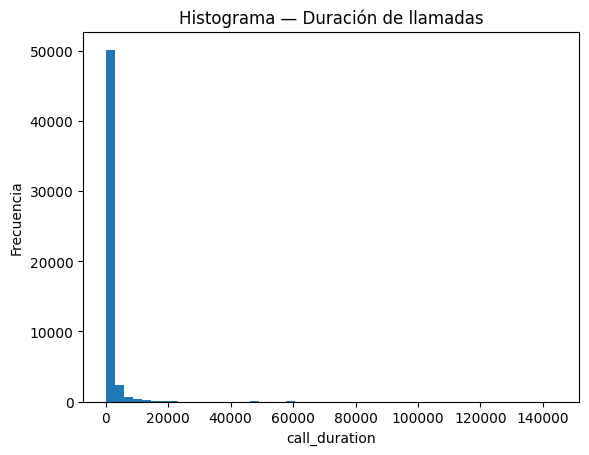

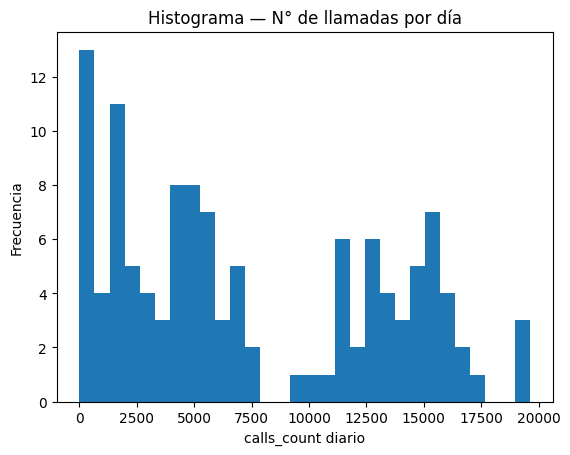

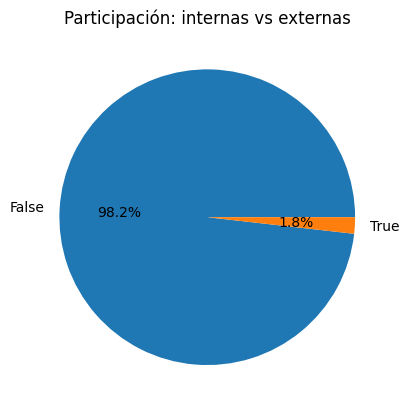

In [19]:
# Resúmenes rápidos
print('Distribución por "direction":')
print(calls['direction'].value_counts(dropna=False))

if 'internal' in calls.columns:
    print('\nDistribución llamadas internas vs externas:')
    print(calls['internal'].value_counts(dropna=False))

# Histograma: duración de llamadas
plt.figure()
calls['call_duration'].dropna().plot(kind='hist', bins=50, title='Histograma — Duración de llamadas')
plt.xlabel('call_duration'); plt.ylabel('Frecuencia'); plt.show()

# Histograma: número de llamadas por día
daily_calls = calls.groupby('date', as_index=False)['calls_count'].sum()
plt.figure()
plt.hist(daily_calls['calls_count'].dropna(), bins=30)
plt.title('Histograma — N° de llamadas por día')
plt.xlabel('calls_count diario'); plt.ylabel('Frecuencia'); plt.show()

# Pie: internas vs externas 
if 'internal' in calls.columns:
    plt.figure()
    pie_vals = calls.groupby('internal')['calls_count'].sum()
    plt.pie(pie_vals.values, labels=pie_vals.index.astype(str), autopct='%1.1f%%')
    plt.title('Participación: internas vs externas'); plt.show()

### KPIs por Operador

In [20]:
# Separar por dirección
inbound = calls[calls['direction'] == 'in'].copy()
outbound = calls[calls['direction'] == 'out'].copy()

# KPIs inbound
if 'is_missed_call' in inbound.columns:
    inbound_agg = inbound.groupby('operator_id', as_index=False).agg(
        inbound_calls=('calls_count','sum'),
        inbound_missed=('is_missed_call','sum'),
        inbound_wait_time_sum=('wait_time','sum')
    )
    inbound_agg['inbound_missed_rate'] = (
        inbound_agg['inbound_missed'] / inbound_agg['inbound_calls'].replace({0: np.nan})
    )
    inbound_agg['inbound_wait_time_mean'] = (
        inbound_agg['inbound_wait_time_sum'] / inbound_agg['inbound_calls'].replace({0: np.nan})
    )
else:
    inbound_agg = inbound.groupby('operator_id', as_index=False).agg(
        inbound_calls=('calls_count','sum'),
        inbound_wait_time_sum=('wait_time','sum')
    )
    inbound_agg['inbound_missed_rate'] = np.nan
    inbound_agg['inbound_wait_time_mean'] = (
        inbound_agg['inbound_wait_time_sum'] / inbound_agg['inbound_calls'].replace({0: np.nan})
    )

# KPIs outbound
outbound_agg = outbound.groupby('operator_id', as_index=False).agg(
    outbound_calls=('calls_count','sum')
)

# Merge
kpis = inbound_agg.merge(outbound_agg, on='operator_id', how='outer').fillna(0)

# Anexar user_id para segmentar
op_user = calls.groupby(['user_id','operator_id'], as_index=False)['calls_count'].sum()[['user_id','operator_id']]
kpis = kpis.merge(op_user, on='operator_id', how='left')

kpis.head()

,operator_id,inbound_calls,inbound_missed,inbound_wait_time_sum,inbound_missed_rate,inbound_wait_time_mean,outbound_calls,user_id
0,879896.0,60.0,0,619.0,0.0,10.316667,1071.0,166406
1,879898.0,118.0,0,1805.0,0.0,15.296610,7856.0,166406
2,880020.0,8.0,0,58.0,0.0,7.250000,46.0,166377
3,880022.0,8.0,0,112.0,0.0,14.000000,211.0,166377
4,880026.0,25.0,0,150.0,0.0,6.000000,2414.0,166377


### Umbrales por Percentiles

Criterios:
- `inbound_missed_rate` **alto**: > P75
- `inbound_wait_time_mean` **alto**: > P75
- `outbound_calls` **bajo**: < P25 (si el rol incluye salidas)

Se considera **ineficaz** si cumple (missed alto **o** wait alto) **y/o** outbound bajo.


In [21]:
# Umbrales por percentiles
p75_missed = kpis['inbound_missed_rate'].replace([np.inf,-np.inf], np.nan).quantile(0.75)
p75_wait   = kpis['inbound_wait_time_mean'].replace([np.inf,-np.inf], np.nan).quantile(0.75)
p25_out    = kpis['outbound_calls'].replace([np.inf,-np.inf], np.nan).quantile(0.25)

kpis['flag_missed_high'] = kpis['inbound_missed_rate'] > p75_missed
kpis['flag_wait_high']   = kpis['inbound_wait_time_mean'] > p75_wait
kpis['flag_out_low']     = kpis['outbound_calls'] < p25_out

kpis['inefficient_core'] = kpis['flag_missed_high'] | kpis['flag_wait_high']
kpis['inefficient'] = kpis['inefficient_core'] | kpis['flag_out_low']

kpis.sort_values(['flag_missed_high','flag_wait_high','flag_out_low','inbound_missed_rate','inbound_wait_time_mean'],
                 ascending=[False, False, True, False, False]).head(15)

,operator_id,inbound_calls,inbound_missed,inbound_wait_time_sum,inbound_missed_rate,inbound_wait_time_mean,outbound_calls,user_id,flag_missed_high,flag_wait_high,flag_out_low,inefficient_core,inefficient
109,897872.0,4.0,1,82.0,0.25,20.500000,53.0,166619,True,True,False,True,True
33,888532.0,12.0,2,289.0,0.166667,24.083333,206.0,166407,True,True,False,True,True
31,888406.0,9.0,1,255.0,0.111111,28.333333,6.0,166669,True,True,False,True,True
403,926490.0,11.0,1,246.0,0.090909,22.363636,144.0,167172,True,True,False,True,True
494,937368.0,23.0,2,544.0,0.086957,23.652174,11.0,167580,True,True,False,True,True
137,900746.0,26.0,2,611.0,0.076923,23.500000,51.0,166946,True,True,False,True,True
598,944226.0,202.0,15,8850.0,0.074257,43.811881,134.0,167977,True,True,False,True,True
16,884408.0,41.0,3,1074.0,0.073171,26.195122,25.0,166503,True,True,False,True,True
594,944216.0,288.0,21,10295.0,0.072917,35.746528,147.0,167977,True,True,False,True,True
700,958416.0,15.0,1,285.0,0.066667,19.000000,310.0,168336,True,True,False,True,True



### Pruebas de Hipótesis (Bonferroni)

**Hipótesis:**
- **H₀:** La tasa de llamadas entrantes perdidas es igual entre operadores.  
- **H₁:** Al menos un operador presenta una tasa superior significativa.

Usaremos la prueba **Mann–Whitney U** para comparar la **tasa de llamadas entrantes perdidas (`inbound_missed_rate`)** de cada operador contra el resto, aplicando la **corrección de Bonferroni** para múltiples comparaciones.

**Pasos:**
1. Comparamos cada operador con el conjunto complementario (resto de operadores).  
2. Aplicamos la prueba **Mann–Whitney U** con `alternative='greater'`.  
3. Ajustamos los p-values con Bonferroni:  
   \( p_{ajustado} = p \times n_{comparaciones} \)  
4. Reportamos los operadores cuya diferencia sigue siendo significativa (**p_adj < 0.05**).

In [26]:
# Pruebas de hipótesis: inbound_missed_rate (Bonferroni)
from scipy.stats import mannwhitneyu
import pandas as pd

alpha = 0.05
p_values = []

# Lista de operadores a comparar
ops = kpis['operator_id'].dropna().unique()

for op in ops:
    group_op = kpis.loc[kpis['operator_id'] == op, 'inbound_missed_rate'].dropna()
    group_rest = kpis.loc[kpis['operator_id'] != op, 'inbound_missed_rate'].dropna()
    
    if len(group_op) > 3 and len(group_rest) > 3:

        stat, p = mannwhitneyu(group_op, group_rest, alternative='greater')
        p_values.append({'operator_id': op, 'U': stat, 'p_value': p})

# Crear DataFrame con resultados
p_df = pd.DataFrame(p_values)

if not p_df.empty:
    # Corrección Bonferroni
    p_df['p_adj'] = p_df['p_value'] * len(p_df)
    p_df['p_adj'] = p_df['p_adj'].clip(upper=1.0)
    p_df['significativo'] = p_df['p_adj'] < alpha

    # Ordenar resultados
    p_df = p_df.sort_values('p_adj').reset_index(drop=True)

    print("Resultados ajustados con Bonferroni:")
    display(p_df.head(10))

    print("\\nOperadores con tasa de llamadas perdidas significativamente superior:")
    display(p_df[p_df['significativo']])
else:
    print("No se pudieron calcular comparaciones válidas (datos insuficientes).")



No se pudieron calcular comparaciones válidas (datos insuficientes).


### Hipótesis alternativa

Hipótesis:
H₀: El número de llamadas atendidas (calls_count) no difiere entre operadores.
H₁: Al menos un operador atiende un volumen significativamente menor de llamadas.

Justificación:
Usa datos abundantes (variabilidad diaria o por cliente).
Se alinea con el objetivo del proyecto (detectar ineficiencia).
Permite una prueba con corrección Bonferroni o Kruskal–Wallis sin problemas de tamaño muestral.


In [31]:
# Hipótesis:
# H0: El número de llamadas atendidas no difiere entre operadores.
# H1: Al menos un operador atiende un volumen significativamente menor.

from scipy.stats import mannwhitneyu
import pandas as pd

alpha = 0.05
p_values = []

ops = calls['operator_id'].dropna().unique()

for op in ops:
    group_op = calls.loc[calls['operator_id'] == op, 'calls_count'].dropna()
    group_rest = calls.loc[calls['operator_id'] != op, 'calls_count'].dropna()
    
    if len(group_op) > 3 and len(group_rest) > 3:
        stat, p = mannwhitneyu(group_op, group_rest, alternative='less')  # 'less' porque menor volumen = ineficiencia
        p_values.append({'operator_id': op, 'U': stat, 'p_value': p})

p_df = pd.DataFrame(p_values)

if not p_df.empty:
    # Corrección Bonferroni
    p_df['p_adj'] = p_df['p_value'] * len(p_df)
    p_df['p_adj'] = p_df['p_adj'].clip(upper=1.0)
    p_df['significativo'] = p_df['p_adj'] < alpha

    p_df = p_df.sort_values('p_adj').reset_index(drop=True)

    print("Resultados ajustados con Bonferroni (calls_count):")
    display(p_df.head(10))

    print("\\nOperadores con volumen de llamadas significativamente menor:")
    display(p_df[p_df['significativo']])
else:
    print("No se pudieron calcular comparaciones válidas (datos insuficientes).")

Resultados ajustados con Bonferroni (calls_count):


,operator_id,U,p_value,p_adj,significativo
0,896016.0,2379436.0,7.504321e-23,6.761393e-20,True
1,924960.0,2178836.0,9.398999e-22,8.468498e-19,True
2,888534.0,2136201.5,2.197022e-20,1.979517e-17,True
3,907952.0,1654558.5,1.447645e-19,1.304328e-16,True
4,907224.0,2620041.0,5.000697e-17,4.505628e-14,True
5,900194.0,836835.5,1.981058e-16,1.784934e-13,True
6,907982.0,1219995.0,2.785690e-16,2.509907e-13,True
7,900894.0,2370397.0,1.404671e-15,1.265609e-12,True
8,901584.0,2229651.0,5.988412e-15,5.395560e-12,True
9,907994.0,1247579.5,1.231688e-14,1.109751e-11,True


\nOperadores con volumen de llamadas significativamente menor:


,operator_id,U,p_value,p_adj,significativo
0,896016.0,2379436.0,7.504321e-23,6.761393e-20,True
1,924960.0,2178836.0,9.398999e-22,8.468498e-19,True
2,888534.0,2136201.5,2.197022e-20,1.979517e-17,True
3,907952.0,1654558.5,1.447645e-19,1.304328e-16,True
4,907224.0,2620041.0,5.000697e-17,4.505628e-14,True
...,...,...,...,...,...
174,958470.0,130755.0,3.793948e-05,3.418347e-02,True
175,930814.0,112939.0,3.949492e-05,3.558493e-02,True
176,904204.0,416082.0,4.944116e-05,4.454648e-02,True
177,891160.0,1711927.0,4.978830e-05,4.485926e-02,True


## Exportación de resultados a Tableau

Para visualizar los hallazgos en Tableau Public, se exportan los resultados del análisis con los KPIs y la clasificación de operadores ineficaces.  
Esta tabla permite crear dashboards interactivos que muestren:

- **Volumen total de llamadas por operador.**  
- **Tasa de llamadas entrantes perdidas.**  
- **Tiempo de espera promedio.**  
- **Identificación de operadores con desempeño significativamente menor (Bonferroni).**  

El archivo generado puede subirse directamente a Tableau Public.


In [33]:
# Exportar resultados para Tableau

# Unir resultados estadísticos al DataFrame de KPIs
export_df = kpis.merge(p_df[['operator_id', 'p_value', 'p_adj', 'significativo']], on='operator_id', how='left')

# Limpiar columnas clave y mantener métricas de interés
cols_export = [
    'operator_id', 'user_id',
    'inbound_calls', 'inbound_missed', 'inbound_missed_rate',
    'inbound_wait_time_mean', 'outbound_calls',
    'flag_missed_high', 'flag_wait_high', 'flag_out_low', 'inefficient',
    'p_value', 'p_adj', 'significativo'
]

export_df = export_df[[c for c in cols_export if c in export_df.columns]].copy()

# Crear columna interpretativa para Tableau
export_df['inefficiency_reason'] = export_df.apply(
    lambda x: 'Volumen significativamente bajo (Bonferroni)' if x['significativo'] else 'Dentro del promedio',
    axis=1
)

# Guardar CSV limpio
export_path = 'telecom_dashboard_data.csv'
export_df.to_csv(export_path, index=False)

print(f"Archivo exportado correctamente: {export_path}")
export_df.head(10)


Archivo exportado correctamente: telecom_dashboard_data.csv


,operator_id,user_id,inbound_calls,inbound_missed,inbound_missed_rate,inbound_wait_time_mean,outbound_calls,flag_missed_high,flag_wait_high,flag_out_low,inefficient,p_value,p_adj,significativo,inefficiency_reason
0,879896.0,166406,60.0,0,0.0,10.316667,1071.0,False,False,False,False,1.527124e-04,0.137594,False,Dentro del promedio
1,879898.0,166406,118.0,0,0.0,15.296610,7856.0,False,False,False,False,1.000000e+00,1.000000,False,Dentro del promedio
2,880020.0,166377,8.0,0,0.0,7.250000,46.0,False,False,False,False,2.926683e-04,0.263694,False,Dentro del promedio
3,880022.0,166377,8.0,0,0.0,14.000000,211.0,False,False,False,False,5.232088e-07,0.000471,True,Volumen significativamente bajo (Bonferroni)
4,880026.0,166377,25.0,0,0.0,6.000000,2414.0,False,False,False,False,1.000000e+00,1.000000,False,Dentro del promedio
5,880028.0,166377,70.0,0,0.0,5.685714,2836.0,False,False,False,False,1.000000e+00,1.000000,False,Dentro del promedio
6,882476.0,166391,3.0,0,0.0,31.666667,0.0,False,True,True,True,NaN,NaN,NaN,Volumen significativamente bajo (Bonferroni)
7,882478.0,166391,3.0,0,0.0,25.333333,1.0,False,True,True,True,NaN,NaN,NaN,Volumen significativamente bajo (Bonferroni)
8,882680.0,166428,109.0,3,0.027523,15.660550,0.0,True,False,True,True,1.104219e-06,0.000995,True,Volumen significativamente bajo (Bonferroni)
9,882684.0,166405,643.0,4,0.006221,15.505443,721.0,True,False,False,True,9.702024e-01,1.000000,False,Dentro del promedio


## Tableau Dashboard:

https://public.tableau.com/views/TelecomDashboard-OperatorEfficiencyErikaG/CallMeMaybeDashboard?:language=en-GB&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link


## PDF Presentación del Projecto: 

https://drive.google.com/file/d/1za55mlbeTDXY2BwK6MFTISn_jWgnbrtk/view?usp=sharing

## ReadMe :

https://drive.google.com/file/d/1rObiDQpvVdRWtoWXS0u8_cXQv_LQbxdA/view?usp=sharing

## Comentario general del revisor